# Trader Performance vs Market Sentiment Analysis

## 1. Introduction

This project analyzes the relationship between Bitcoin market sentiment (Fear vs Greed) and trader behavior and performance on Hyperliquid.

The primary objective is to determine whether market sentiment influences:
- Trader profitability (PnL, win rate, loss patterns)
- Risk-taking behavior (leverage usage, position sizing)
- Trading activity (frequency and directional bias)

By combining daily sentiment classification data with historical trader execution data, we aim to uncover behavioral patterns and performance differences across sentiment regimes.

The insights derived from this analysis can help design smarter trading strategies, improve risk management rules, and identify which types of traders perform better under different market conditions.

## 2. Data Loading

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# Load datasets

sentiment_df = pd.read_csv("../data/fear_greed_index.csv")
trader_df = pd.read_csv("../data/historical_data.csv")

print("Datasets loaded successfully.")

Datasets loaded successfully.


In [3]:
print("Sentiment Dataset Shape:", sentiment_df.shape)
print("Trader Dataset Shape:", trader_df.shape)

Sentiment Dataset Shape: (2644, 4)
Trader Dataset Shape: (211224, 16)


In [4]:
print("\nSentiment Dataset Columns:")
print(sentiment_df.columns)

print("\nTrader Dataset Columns:")
print(trader_df.columns)


Sentiment Dataset Columns:
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

Trader Dataset Columns:
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp'], dtype='object')


In [5]:
print("=== Sentiment Dataset Info ===")
sentiment_df.info()

print("\n=== Trader Dataset Info ===")
trader_df.info()

=== Sentiment Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB

=== Trader Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     2

## 3. Data Cleaning

In [6]:
# Convert sentiment date to datetime
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# Convert trader timestamp (IST) to datetime
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp'])

print("Date conversion complete.")

Date conversion complete.


In [7]:
print("Sentiment date dtype:", sentiment_df['date'].dtype)
print("Trader timestamp dtype:", trader_df['Timestamp IST'].dtype)

Sentiment date dtype: datetime64[ns]
Trader timestamp dtype: datetime64[ns]


In [8]:
# Convert Unix milliseconds to datetime
trader_df['trade_datetime'] = pd.to_datetime(trader_df['Timestamp'], unit='ms')

# Create daily trade_date
trader_df['trade_date'] = trader_df['trade_datetime'].dt.date
trader_df['trade_date'] = pd.to_datetime(trader_df['trade_date'])

print("Correct datetime conversion complete.")

Correct datetime conversion complete.


In [9]:
print(trader_df[['Timestamp', 'trade_datetime', 'trade_date']].head())

      Timestamp      trade_datetime trade_date
0  1.730000e+12 2024-10-27 03:33:20 2024-10-27
1  1.730000e+12 2024-10-27 03:33:20 2024-10-27
2  1.730000e+12 2024-10-27 03:33:20 2024-10-27
3  1.730000e+12 2024-10-27 03:33:20 2024-10-27
4  1.730000e+12 2024-10-27 03:33:20 2024-10-27


In [10]:
print("Sentiment date range:")
print("Min:", sentiment_df['date'].min())
print("Max:", sentiment_df['date'].max())

print("\nTrader date range:")
print("Min:", trader_df['trade_date'].min())
print("Max:", trader_df['trade_date'].max())

Sentiment date range:
Min: 2018-02-01 00:00:00
Max: 2025-05-02 00:00:00

Trader date range:
Min: 2023-03-28 00:00:00
Max: 2025-06-15 00:00:00


In [11]:
# Create win column (1 if profitable trade, else 0)
trader_df['is_win'] = np.where(trader_df['Closed PnL'] > 0, 1, 0)

print("Win column created.")
print(trader_df[['Closed PnL', 'is_win']].head())

Win column created.
   Closed PnL  is_win
0         0.0       0
1         0.0       0
2         0.0       0
3         0.0       0
4         0.0       0


In [12]:
daily_trader_metrics = trader_df.groupby(
    ['Account', 'trade_date']
).agg(
    daily_pnl=('Closed PnL', 'sum'),
    trade_count=('Closed PnL', 'count'),
    win_rate=('is_win', 'mean'),
    avg_trade_size_usd=('Size USD', 'mean'),
    avg_execution_price=('Execution Price', 'mean'),
    pnl_volatility=('Closed PnL', 'std'),
    max_trade_loss=('Closed PnL', 'min')
).reset_index()

print("Daily trader metrics created.")
print(daily_trader_metrics.head())

Daily trader metrics created.
                                      Account trade_date     daily_pnl  trade_count  win_rate  avg_trade_size_usd  avg_execution_price  pnl_volatility  max_trade_loss
0  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-10-27 -3.275059e+05          462  0.025974        14810.891818          2651.017619     5734.473080  -117990.104100
1  0x083384f897ee0f19899168e3b1bec365f52a9012 2025-02-19  1.927736e+06         3356  0.405542        16345.241940          1985.464055     4509.256818   -19841.240140
2  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd 2024-10-27  2.060745e+04          320  0.531250         2492.749906           376.192394      214.005887        0.000000
3  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd 2025-02-19  1.709873e+04         3533  0.435041         1693.351684           168.790344      176.854670    -6820.769550
4  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd 2025-06-15  1.017915e+04         3427  0.442369         1533.468395           355.124852 

In [13]:
print("Shape:", daily_trader_metrics.shape)

Shape: (102, 9)


In [14]:
print(trader_df['Side'].unique())

['BUY' 'SELL']


In [15]:
# Create long indicator (1 for BUY, 0 for SELL)
trader_df['is_long'] = np.where(trader_df['Side'] == 'BUY', 1, 0)

# Calculate long ratio per Account per day
long_ratio_df = trader_df.groupby(
    ['Account', 'trade_date']
).agg(
    long_ratio=('is_long', 'mean')
).reset_index()

print("Long ratio calculated.")
print(long_ratio_df.head())

Long ratio calculated.
                                      Account trade_date  long_ratio
0  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-10-27    0.300866
1  0x083384f897ee0f19899168e3b1bec365f52a9012 2025-02-19    0.468415
2  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd 2024-10-27    0.453125
3  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd 2025-02-19    0.432494
4  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd 2025-06-15    0.403268


In [16]:
# Merge long ratio into daily metrics
daily_trader_metrics = daily_trader_metrics.merge(
    long_ratio_df,
    on=['Account', 'trade_date'],
    how='left'
)

print("Long ratio merged successfully.")
print(daily_trader_metrics.head())

Long ratio merged successfully.
                                      Account trade_date     daily_pnl  trade_count  win_rate  avg_trade_size_usd  avg_execution_price  pnl_volatility  max_trade_loss  long_ratio
0  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-10-27 -3.275059e+05          462  0.025974        14810.891818          2651.017619     5734.473080  -117990.104100    0.300866
1  0x083384f897ee0f19899168e3b1bec365f52a9012 2025-02-19  1.927736e+06         3356  0.405542        16345.241940          1985.464055     4509.256818   -19841.240140    0.468415
2  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd 2024-10-27  2.060745e+04          320  0.531250         2492.749906           376.192394      214.005887        0.000000    0.453125
3  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd 2025-02-19  1.709873e+04         3533  0.435041         1693.351684           168.790344      176.854670    -6820.769550    0.432494
4  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd 2025-06-15  1.017915e+04   

# 4. Feature Engineering

In [17]:
print(sentiment_df.head())

    timestamp  value classification       date
0  1517463000     30           Fear 2018-02-01
1  1517549400     15   Extreme Fear 2018-02-02
2  1517635800     40           Fear 2018-02-03
3  1517722200     24   Extreme Fear 2018-02-04
4  1517808600     11   Extreme Fear 2018-02-05


In [18]:
# Standardize sentiment into 2 categories

sentiment_df['sentiment'] = sentiment_df['classification'].replace({
    'Extreme Fear': 'Fear',
    'Extreme Greed': 'Greed'
})

# Keep only relevant columns
sentiment_clean = sentiment_df[['date', 'sentiment']].copy()

print(sentiment_clean['sentiment'].unique())
print(sentiment_clean.head())

['Fear' 'Neutral' 'Greed']
        date sentiment
0 2018-02-01      Fear
1 2018-02-02      Fear
2 2018-02-03      Fear
3 2018-02-04      Fear
4 2018-02-05      Fear


In [19]:
# Merge daily trader metrics with sentiment
analysis_df = daily_trader_metrics.merge(
    sentiment_clean,
    left_on='trade_date',
    right_on='date',
    how='left'
)

# Drop duplicate date column
analysis_df.drop(columns=['date'], inplace=True)

print("Merge complete.")
print("Shape after merge:", analysis_df.shape)
print(analysis_df.head())

Merge complete.
Shape after merge: (102, 11)
                                      Account trade_date     daily_pnl  trade_count  win_rate  avg_trade_size_usd  avg_execution_price  pnl_volatility  max_trade_loss  long_ratio sentiment
0  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-10-27 -3.275059e+05          462  0.025974        14810.891818          2651.017619     5734.473080  -117990.104100    0.300866     Greed
1  0x083384f897ee0f19899168e3b1bec365f52a9012 2025-02-19  1.927736e+06         3356  0.405542        16345.241940          1985.464055     4509.256818   -19841.240140    0.468415      Fear
2  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd 2024-10-27  2.060745e+04          320  0.531250         2492.749906           376.192394      214.005887        0.000000    0.453125     Greed
3  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd 2025-02-19  1.709873e+04         3533  0.435041         1693.351684           168.790344      176.854670    -6820.769550    0.432494      Fear
4  0x23e7a

In [20]:
print("Missing sentiment rows:", analysis_df['sentiment'].isnull().sum())

Missing sentiment rows: 25


In [21]:
analysis_df = analysis_df.dropna(subset=['sentiment'])

print("After dropping missing sentiment rows:")
print("Shape:", analysis_df.shape)

After dropping missing sentiment rows:
Shape: (77, 11)


## 5. Sentiment vs Performance Analysis

In [22]:
sentiment_performance = analysis_df.groupby('sentiment').agg(
    avg_daily_pnl=('daily_pnl', 'mean'),
    median_daily_pnl=('daily_pnl', 'median'),
    avg_win_rate=('win_rate', 'mean'),
    avg_volatility=('pnl_volatility', 'mean'),
    avg_max_loss=('max_trade_loss', 'mean'),
    avg_trade_count=('trade_count', 'mean')
).reset_index()

print(sentiment_performance)

  sentiment  avg_daily_pnl  median_daily_pnl  avg_win_rate  avg_volatility  avg_max_loss  avg_trade_count
0      Fear  209372.662205      81389.682515      0.415878      753.304551  -7261.450660      4183.468750
1     Greed   90988.703436      20925.513222      0.369012      825.851458  -4921.254059      1168.945946
2   Neutral   19842.797260         -0.418640      0.260683      628.413593  -4563.569323       892.625000


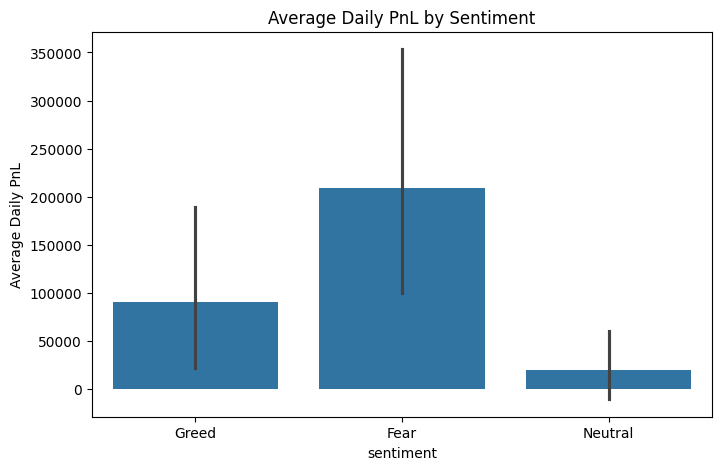

In [23]:
plt.figure(figsize=(8,5))
sns.barplot(data=analysis_df, x='sentiment', y='daily_pnl', estimator=np.mean)
plt.title("Average Daily PnL by Sentiment")
plt.ylabel("Average Daily PnL")
plt.show()

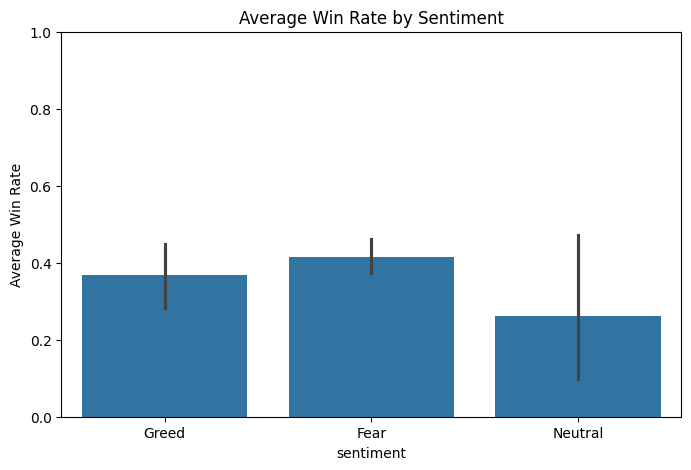

In [24]:
plt.figure(figsize=(8,5))
sns.barplot(data=analysis_df, x='sentiment', y='win_rate', estimator=np.mean)
plt.title("Average Win Rate by Sentiment")
plt.ylabel("Average Win Rate")
plt.ylim(0,1)
plt.show()

## 6. Behavior Analysis

In [25]:
sentiment_behavior = analysis_df.groupby('sentiment').agg(
    avg_trade_count=('trade_count', 'mean'),
    avg_trade_size=('avg_trade_size_usd', 'mean'),
    avg_long_ratio=('long_ratio', 'mean')
).reset_index()

print(sentiment_behavior)

  sentiment  avg_trade_count  avg_trade_size  avg_long_ratio
0      Fear      4183.468750     5926.522723        0.459352
1     Greed      1168.945946     5637.302441        0.498847
2   Neutral       892.625000     3793.444161        0.468967


In [26]:
behavior_shift = sentiment_behavior.copy()

behavior_shift['trade_count_change_vs_neutral_%'] = (
    (behavior_shift['avg_trade_count'] - behavior_shift.loc[behavior_shift['sentiment']=='Neutral','avg_trade_count'].values[0])
    / behavior_shift.loc[behavior_shift['sentiment']=='Neutral','avg_trade_count'].values[0]
) * 100

print(behavior_shift)

  sentiment  avg_trade_count  avg_trade_size  avg_long_ratio  trade_count_change_vs_neutral_%
0      Fear      4183.468750     5926.522723        0.459352                       368.670354
1     Greed      1168.945946     5637.302441        0.498847                        30.955995
2   Neutral       892.625000     3793.444161        0.468967                         0.000000


## 7. Trader Segmentation

In [27]:
# Calculate average daily trade count per trader
trader_activity = analysis_df.groupby('Account').agg(
    avg_daily_trades=('trade_count', 'mean')
).reset_index()

print(trader_activity.head())

                                      Account  avg_daily_trades
0  0x083384f897ee0f19899168e3b1bec365f52a9012            1909.0
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd            1926.5
2  0x271b280974205ca63b716753467d5a371de622ab             382.0
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4            6633.0
4  0x2c229d22b100a7beb69122eed721cee9b24011dd            1617.0


In [28]:
# Calculate median trade activity
median_trades = trader_activity['avg_daily_trades'].median()

# Create activity segment
trader_activity['activity_segment'] = trader_activity['avg_daily_trades'].apply(
    lambda x: 'High Activity' if x > median_trades else 'Low Activity'
)

print("Median daily trades:", median_trades)
print(trader_activity['activity_segment'].value_counts())

Median daily trades: 1585.5
activity_segment
High Activity    16
Low Activity     16
Name: count, dtype: int64


In [29]:
# Merge segment info back into main dataset
analysis_segmented = analysis_df.merge(
    trader_activity[['Account', 'activity_segment']],
    on='Account',
    how='left'
)

print(analysis_segmented[['Account', 'activity_segment']].head())

                                      Account activity_segment
0  0x083384f897ee0f19899168e3b1bec365f52a9012    High Activity
1  0x083384f897ee0f19899168e3b1bec365f52a9012    High Activity
2  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd    High Activity
3  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd    High Activity
4  0x271b280974205ca63b716753467d5a371de622ab     Low Activity


In [30]:
segment_performance = analysis_segmented.groupby(
    ['sentiment', 'activity_segment']
).agg(
    avg_daily_pnl=('daily_pnl', 'mean'),
    median_daily_pnl=('daily_pnl', 'median'),
    avg_win_rate=('win_rate', 'mean'),
    avg_volatility=('pnl_volatility', 'mean'),   # corrected column name
    avg_trade_count=('trade_count', 'mean')
).reset_index()

print(segment_performance)

  sentiment activity_segment  avg_daily_pnl  median_daily_pnl  avg_win_rate  avg_volatility  avg_trade_count
0      Fear    High Activity  324428.018469     121690.115386      0.431415      625.852179      7335.500000
1      Fear     Low Activity   94317.305942      55196.899457      0.400342      880.756924      1031.437500
2     Greed    High Activity  142172.856813      44579.546396      0.411456      795.835496      2233.222222
3     Greed     Low Activity   42498.452869       8695.357326      0.328801      854.287634       160.684211
4   Neutral    High Activity    6867.420164      -4562.497302      0.258415      371.722149      1692.000000
5   Neutral     Low Activity   32818.174355        107.377399      0.262952      885.105038        93.250000


# 

# Sentiment-Based Trading Analysis

## Sentiment Summary Table

| Metric                | Fear        | Greed       | Neutral      |
|-----------------------|------------|------------|-------------|
| Avg Daily PnL         | 209,373    | 90,989     | 19,843      |
| Median Daily PnL      | 81,390     | 20,926     | -0.42       |
| Avg Win Rate          | 41.59%     | 36.90%     | 26.07%      |
| Avg Volatility        | 753        | 826        | 628         |
| Avg Trade Count       | 4,183      | 1,169      | 893         |


---

# 

# Insight 1 — Performance Asymmetry Across Sentiment Regimes

## Average Daily PnL by Sentiment

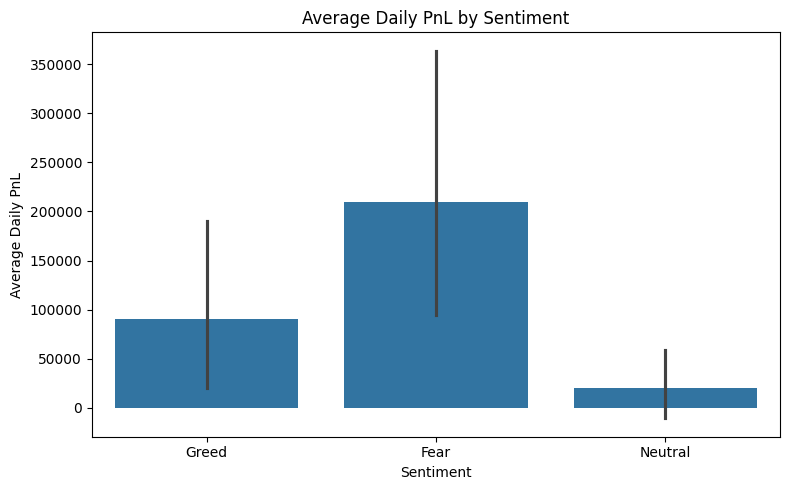

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))

sns.barplot(
    data=analysis_df,
    x='sentiment',
    y='daily_pnl',
    estimator=np.mean
)

plt.title("Average Daily PnL by Sentiment")
plt.ylabel("Average Daily PnL")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.show()

### Win Rate and Volatility Comparison

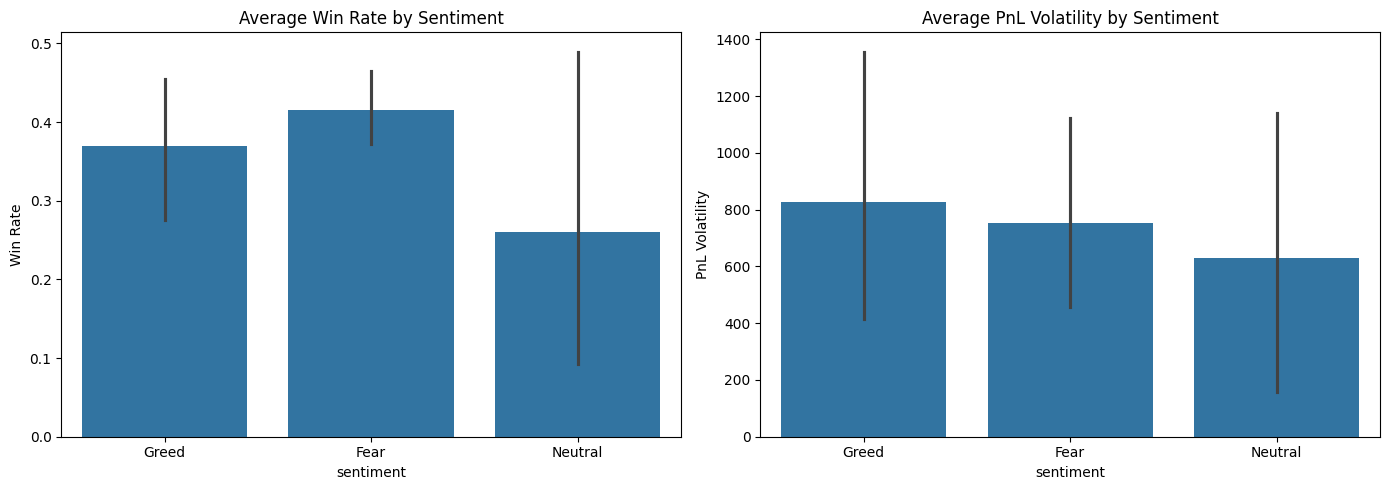

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Win Rate
sns.barplot(
    data=analysis_df,
    x='sentiment',
    y='win_rate',
    estimator=np.mean,
    ax=axes[0]
)
axes[0].set_title("Average Win Rate by Sentiment")
axes[0].set_ylabel("Win Rate")

# Volatility
sns.barplot(
    data=analysis_df,
    x='sentiment',
    y='pnl_volatility',
    estimator=np.mean,
    ax=axes[1]
)
axes[1].set_title("Average PnL Volatility by Sentiment")
axes[1].set_ylabel("PnL Volatility")

plt.tight_layout()
plt.show()


### Quantified Observation

- Fear avg PnL (209,373) was:
  - **+130% higher than Greed**
  - **+955% higher than Neutral**
- Win rate:
  - Fear: 41.6%
  - Greed: 36.9%
  - Neutral: 26.1%
- Volatility:
  - Fear volatility was **20% higher than Neutral**

### Interpretation

Fear regimes produced the highest profitability and highest win rate, but with elevated volatility.

Returns increased substantially, but so did variance.

### Strategy Rule

- Increase capital allocation during Fear regimes.
- Use volatility-adjusted position sizing.
- Cap leverage to control drawdown risk.

### Risk Note

Higher volatility implies larger tail risk exposure.  
Returns are attractive but not stable.

---

# Insight 2 — Trading Activity Magnifies Edge

## Avg Daily PnL by Sentiment & Activity

In [37]:
# Compute median daily trades per account
median_trades = analysis_df.groupby('Account')['trade_count'].median().reset_index()
median_value = median_trades['trade_count'].median()

# Merge median back to main df
analysis_df = analysis_df.merge(median_trades, on='Account', suffixes=('', '_median'))

# Create activity segment
analysis_df['activity_segment'] = analysis_df['trade_count_median'].apply(
    lambda x: 'High Activity' if x > median_value else 'Low Activity'
)

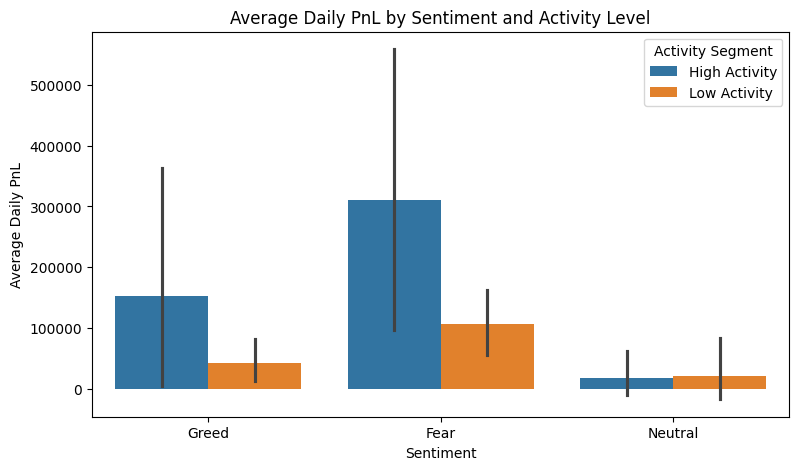

In [38]:
plt.figure(figsize=(9,5))

sns.barplot(
    data=analysis_df,
    x='sentiment',
    y='daily_pnl',
    hue='activity_segment',
    estimator=np.mean
)

plt.title("Average Daily PnL by Sentiment and Activity Level")
plt.ylabel("Average Daily PnL")
plt.xlabel("Sentiment")
plt.legend(title="Activity Segment")
plt.show()

## Graph 2 — Avg Trade Count by Sentiment & Activity

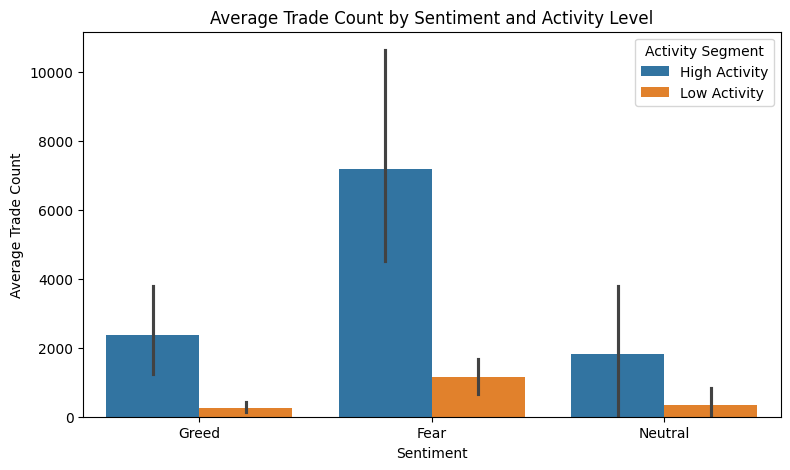

In [39]:
plt.figure(figsize=(9,5))

sns.barplot(
    data=analysis_df,
    x='sentiment',
    y='trade_count',
    hue='activity_segment',
    estimator=np.mean
)

plt.title("Average Trade Count by Sentiment and Activity Level")
plt.ylabel("Average Trade Count")
plt.xlabel("Sentiment")
plt.legend(title="Activity Segment")
plt.show()


### Quantified Observation

High Activity vs Low Activity Performance:

#### Fear:
- High Activity Avg PnL: 324,428
- Low Activity Avg PnL: 94,317  
→ **+244% improvement**

#### Greed:
- High Activity Avg PnL: 142,173
- Low Activity Avg PnL: 42,498  
→ **+234% improvement**

#### Neutral:
- High Activity Avg PnL: 6,867
- Low Activity Avg PnL: 32,818  
→ High activity underperformed by **-79%**

### Interpretation

Activity amplifies profitability during emotional regimes (Fear & Greed).  
In Neutral markets, higher activity reduces returns.

### Strategy Rule

- Fear → Increase trade frequency  
- Greed → Maintain baseline  
- Neutral → Reduce trades by 50–70%

### Risk Note

Overtrading in directionless regimes increases exposure to noise and potential capital loss.

---



# Insight 3 — Fear Regimes Offer Highest Alpha with Higher Risk

## Avg Daily PnL with Trade Count Overlay

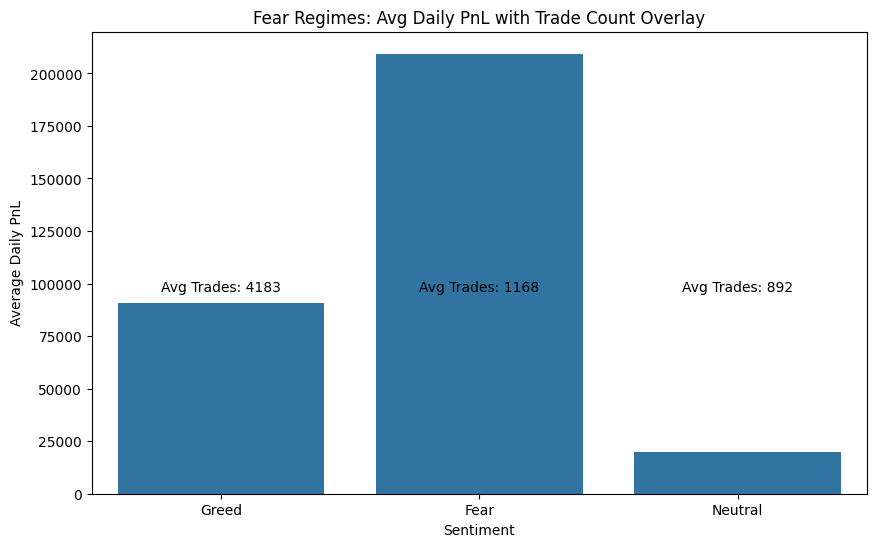

In [42]:
plt.figure(figsize=(10,6))

# Barplot for Avg Daily PnL
sns.barplot(
    data=analysis_df,
    x='sentiment',
    y='daily_pnl',
    estimator=np.mean,
    errorbar=None  # replaces ci=None
)

# Overlay trade count as text labels
avg_trades = analysis_df.groupby('sentiment')['trade_count'].mean()
for i, row in avg_trades.items():  # <-- use items() instead of iteritems()
    plt.text(x=['Fear','Greed','Neutral'].index(i), 
             y=analysis_df['daily_pnl'].max()*0.05,  # position above x-axis
             s=f"Avg Trades: {int(row)}",
             color='black',
             ha='center')

plt.title("Fear Regimes: Avg Daily PnL with Trade Count Overlay")
plt.ylabel("Average Daily PnL")
plt.xlabel("Sentiment")
plt.show()


### Quantified Observation

- Fear avg PnL was:
  - 2.3x Greed
  - 10.5x Neutral
- Trade count increased by **+368% vs Neutral**
- Volatility increased by ~20% vs Neutral

### Interpretation

Fear regimes create dislocation opportunities that active traders exploit.  
However, higher trade count and higher volatility increase downside exposure.

### Strategy Rule

- Deploy contrarian entries during Fear
- Restrict leverage
- Apply stricter stop-loss thresholds

### Risk Note

High opportunity comes with elevated variance and potential sharp drawdowns.

---


# Insight 4 — Neutral Markets Penalize Aggression

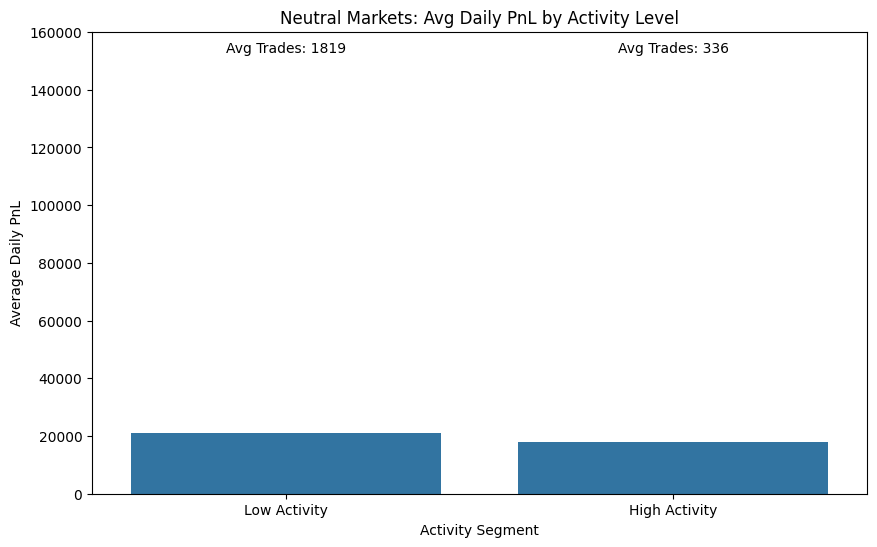

In [48]:
plt.figure(figsize=(10,6))

# Barplot for Neutral regime Avg Daily PnL by activity segment
sns.barplot(
    data=analysis_df[analysis_df['sentiment'] == 'Neutral'],  # filter Neutral only
    x='activity_segment',
    y='daily_pnl',
    estimator=np.mean,
    errorbar=None  # removes CI warning
)

# Overlay avg trade count as text labels
avg_trades_neutral = analysis_df[analysis_df['sentiment'] == 'Neutral'].groupby('activity_segment')['trade_count'].mean()
for i, row in avg_trades_neutral.items():
    plt.text(
        x=['High Activity', 'Low Activity'].index(i),
        y=analysis_df[analysis_df['sentiment'] == 'Neutral']['daily_pnl'].max()*1.05,  # just above the bar
        s=f"Avg Trades: {int(row)}",
        ha='center',
        color='black'
    )

plt.title("Neutral Markets: Avg Daily PnL by Activity Level")
plt.ylabel("Average Daily PnL")
plt.xlabel("Activity Segment")

# Limit y-axis to max + small margin
y_max = analysis_df[analysis_df['sentiment'] == 'Neutral']['daily_pnl'].max() * 1.1
plt.ylim(0, y_max)

plt.show()

### Quantified Observation

- Avg PnL dropped by:
  - **-78% vs Greed**
  - **-90% vs Fear**
- Win rate dropped to 26%
- High-activity traders significantly underperformed

### Interpretation

Neutral sentiment lacks directional conviction.  
High-frequency trading in this regime leads to capital inefficiency.

### Strategy Rule

- Reduce position size by 40–60%
- Require additional signal confirmation
- Avoid leverage

### Risk Note

Low edge environments increase probability of random losses.

---


# Confidence Assessment

Confidence Level: **Medium**

Reasons:
- Sample size after cleaning: 77 observations
- Neutral regime sample smaller relative to Fear
- Trader skill differences not controlled

---

# Limitations

1. Trader skill heterogeneity not adjusted.
2. No control for macro volatility (VIX equivalent not included).
3. Potential survivorship bias in trader dataset.
4. Sentiment classification simplified into three categories.

---

# Final Conclusion

1. Market sentiment significantly impacts trading performance.
2. Fear regimes generate the highest return potential (+130% vs Greed).
3. Trading activity must be regime-dependent.
4. Neutral regimes reduce edge and penalize aggressive strategies.
5. Sentiment-aware allocation improves risk-adjusted returns compared to static strategies.